# Pipeline Flexo — Clusterização com GMM (Gaussian Mixture Model)

Notebook responsável por consolidar os eventos Flexo em uma linha por OP e aplicar **GMM (Gaussian Mixture Model)** para identificar padrões de produção semelhantes.

**Por que GMM ao invés de K-Means?**
- Clustering probabilístico (soft clustering)
- Critérios BIC/AIC para seleção automática de K
- Melhor para dados contínuos multidimensionais
- Fornece probabilidades de pertencimento a cada cluster

## Sumário

1. Setup e carga das bases
2. Preparação e enriquecimento
3. Feature Engineering
4. Seleção de Features para Clusterização
5. Preparação, Normalização e Redução de Dimensionalidade (PCA)
6. Determinação do Número Ótimo de Componentes (K) com BIC/AIC
7. Aplicação do GMM com K Ótimo
8. Análise de Perfil dos Clusters
9. Visualizações dos Clusters
10. Conclusão e Próximos Passos

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option("display.max_columns", None)
np.set_printoptions(suppress=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Setup e carga das bases

In [2]:
DATA_DIR = Path("../../../data")
RAW_DIR = DATA_DIR / "raw"
ML_DIR = DATA_DIR / "ml"

print("Carregando bases brutas...")
df_facas = pd.read_parquet(RAW_DIR / "tb_facas.parquet")
df_flexo = pd.read_parquet(ML_DIR / "table_final_flexo.parquet")
df_pedidos = pd.read_parquet("tb_pedidos_process.parquet")

print(f"tb_facas: {df_facas.shape}")
print(f"table_final_flexo: {df_flexo.shape}")
print(f"tb_pedidos_process: {df_pedidos.shape}")

Carregando bases brutas...
tb_facas: (8180, 4)
table_final_flexo: (70713, 8)
tb_pedidos_process: (150596, 52)


## 2. Preparação e enriquecimento

In [3]:
# Criar identificador único CD_OP
df_pedidos["CD_OP"] = df_pedidos["CD_PEDIDO"] + "/" + df_pedidos["CD_ITEM"]
print(f"✓ CD_OP criado para {len(df_pedidos):,} registros")

✓ CD_OP criado para 150,596 registros


In [4]:
# Merge das bases
df_flexo_pedidos = (
    df_flexo.merge(df_pedidos, on=["CD_OP"], how="inner")
    .merge(df_facas[["CD_FACA", "VL_COMPLAMINA"]], on="CD_FACA", how="left")
    .drop(columns="TX_TIPO_MAQUINA")
)

# Preencher VL_COMPLAMINA faltante
df_flexo_pedidos["VL_COMPLAMINA"] = df_flexo_pedidos["VL_COMPLAMINA"].fillna(0)

print(f"Registros após merge: {df_flexo_pedidos.shape[0]:,}")
print(f"Colunas disponíveis: {df_flexo_pedidos.shape[1]}")


Registros após merge: 33,553
Colunas disponíveis: 59


## 3. Feature Engineering

Criação de features derivadas para melhorar a capacidade de identificar padrões e grupos similares.

In [5]:
print("Criando features derivadas...")

# Aspect ratios (proporções)
df_flexo_pedidos['RAZAO_COMP_LARG'] = df_flexo_pedidos['VL_COMPRIMENTO'] / df_flexo_pedidos['VL_LARGURA'].replace(0, np.nan)
df_flexo_pedidos['RAZAO_INTERNA'] = df_flexo_pedidos['VL_COMPRIMENTOINTERNO'] / df_flexo_pedidos['VL_LARGURAINTERNA'].replace(0, np.nan)

# Volumes e áreas
df_flexo_pedidos['VOLUME_INTERNO'] = (
    df_flexo_pedidos['VL_COMPRIMENTOINTERNO'] * 
    df_flexo_pedidos['VL_LARGURAINTERNA'] * 
    df_flexo_pedidos['VL_ALTURAINTERNA']
)
df_flexo_pedidos['AREA_CHAPA'] = df_flexo_pedidos['VL_COMPRIMENTO'] * df_flexo_pedidos['VL_LARGURA']

# Peças por chapa (aproveitamento)
df_flexo_pedidos['PECAS_POR_CHAPA'] = df_flexo_pedidos['VL_MULTCOMP'] * df_flexo_pedidos['VL_MULTLARG']

# Total de refilo (desperdício)
df_flexo_pedidos['REFILO_TOTAL'] = df_flexo_pedidos['VL_REFILOCOMPRIMENTO'] + df_flexo_pedidos['VL_REFILOLARGURA']

print(f"Features criadas. Shape atual: {df_flexo_pedidos.shape}")
print(f"\nNovas colunas adicionadas:")
new_cols = ['RAZAO_COMP_LARG', 'RAZAO_INTERNA', 'VOLUME_INTERNO', 'AREA_CHAPA', 
            'PECAS_POR_CHAPA', 'REFILO_TOTAL']
for col in new_cols:
    print(f"  - {col}")

Criando features derivadas...
Features criadas. Shape atual: (33553, 64)

Novas colunas adicionadas:
  - RAZAO_COMP_LARG
  - RAZAO_INTERNA
  - VOLUME_INTERNO
  - AREA_CHAPA
  - PECAS_POR_CHAPA
  - REFILO_TOTAL


## 4. Seleção de Features para Clusterização

Vamos selecionar apenas features de **produto** (características técnicas), excluindo:
- Identificadores (CD_OP, CD_ITEM, CD_PEDIDO, CD_FACA)
- Variáveis target/resultado de produção (QT_PRODUZIDA, VL_DURACAO_PRODUCAO, etc.)
- Categóricas de alta cardinalidade (CAT_COMPOSICAO, TX_TIPOABNT)

In [13]:
# Colunas a excluir
colunas_excluir = [
    # Identificadores
    "CD_OP",
    "CD_ITEM",
    "CD_PEDIDO",
    "CD_FACA",
    # Variáveis target (resultados de produção)
    "QT_PRODUZIDA",
    "QT_CHAPASALIMENTADAS",
    "VL_DURACAO_PRODUCAO",
    "QT_PROGRAMADA",
    "VL_DURACAO_PARADAS",
    "QT_PARADAS",
    # Categóricas de alta cardinalidade (analisar DEPOIS do clustering)
    "CAT_COMPOSICAO",
    "TX_TIPOABNT",
    "VL_MULTCOMP",
    "VL_MULTLARG",
    "FL_REFILADO",
    "PECAS_POR_CHAPA",
    "QT_ARRANJO",
    # Redundante com VL_COMPRIMENTO
    "VL_COMPRIMENTO",  # 0.9999 correlação
    # Redundante com VL_LARGURA
    "VL_LARGURA",  # 0.9999 correlação
    # Redundante com RAZAO_COMP_LARG
    "RAZAO_PECA_COMP_LARG",  # 0.9999 correlação
    "RAZAO_CHAPA_COMP_LARG",  # 0.9999 correlação
    # Redundante com AREA_CHAPA ou VL_AREALIQUIDAPECA
    # 'AREA_CHAPA',  # Manter uma das duas
    "VL_AREALIQUIDAPECA",  # Remover (AREA_CHAPA é mais interpretável)
    # Vincos individuais - usar só VL_VINCOS_TOTAL_MM
    "VL_VINCOCOMP1",
    "VL_VINCOCOMP2",
    "VL_VINCOCOMP3",
    "VL_VINCOCOMP4",
    "VL_VINCOCOMP5",
    "VL_VINCOLARG1",
    "VL_VINCOLARG2",
    "VL_VINCOLARG3",
    # Redundante com VL_REFILOCOMPRIMENTO
    "REFILO_TOTAL",
    "AREA_CHAPA",
    "VL_VINCOS_TOTAL_MM",
    "VL_COMPRIMENTOINTERNO",
    "VL_ALTURAINTERNA",
    "VL_LARGURAINTERNA",
    "PECAS_POR_CHAPA",
    "VL_PESOPECA",
    "VL_REFILOCOMPRIMENTO",
    "VL_PESOCAIXA",
]

# Features para clusterização
features_clustering = [col for col in df_flexo_pedidos.columns if col not in colunas_excluir]

print(f"Total de features para clusterização: {len(features_clustering)}")
print(f"\nFeatures selecionadas:")
for i, feat in enumerate(features_clustering, 1):
    print(f"  {i:2d}. {feat}")

Total de features para clusterização: 25

Features selecionadas:
   1. CAT_ESPELHO
   2. CAT_FILME
   3. FL_CONTROLE_ESPECIAL_IMPRESSAO
   4. FL_TESTE_EXIGELAUDO
   5. FL_RESINAINTERNA
   6. PERC_VAR_PEDIDA
   7. VL_COBBINTMAXIMO
   8. QT_NRCORES
   9. QT_PEDIDA
  10. VL_COLUNAMINIMO
  11. VL_COMPPECA
  12. VL_COMPRESSAO
  13. VL_GRAMATURA
  14. VL_LAP
  15. FL_LAP_INTERNO
  16. FL_LAP_NO_COMPR
  17. VL_LARGPECA
  18. VL_REFILOLARGURA
  19. VL_REFUGOCLIENTE
  20. VL_CONSUMO_COR_TOTAL
  21. FL_PROLONGLAP
  22. VOLUME_INTERNO
  23. VL_COMPLAMINA
  24. RAZAO_COMP_LARG
  25. RAZAO_INTERNA


In [ ]:
col_fl = [
    "FL_TESTE_EXIGELAUDO",
    "FL_RESINAINTERNA",
    "FL_CONTROLE_ESPECIAL_IMPRESSAO",
]

df_flexo_pedidos[col_fl] = df_flexo_pedidos[col_fl].astype(int)
df_cluster = df_flexo_pedidos[features_clustering].copy()

In [17]:
df_cluster.columns

Index(['CAT_ESPELHO', 'CAT_FILME', 'FL_CONTROLE_ESPECIAL_IMPRESSAO',
       'FL_TESTE_EXIGELAUDO', 'FL_RESINAINTERNA', 'PERC_VAR_PEDIDA',
       'VL_COBBINTMAXIMO', 'QT_NRCORES', 'QT_PEDIDA', 'VL_COLUNAMINIMO',
       'VL_COMPPECA', 'VL_COMPRESSAO', 'VL_GRAMATURA', 'VL_LAP',
       'FL_LAP_INTERNO', 'FL_LAP_NO_COMPR', 'VL_LARGPECA', 'VL_REFILOLARGURA',
       'VL_REFUGOCLIENTE', 'VL_CONSUMO_COR_TOTAL', 'FL_PROLONGLAP',
       'VOLUME_INTERNO', 'VL_COMPLAMINA', 'RAZAO_COMP_LARG', 'RAZAO_INTERNA'],
      dtype='object')

In [19]:
corr = df_cluster.corr().abs().unstack().sort_values(ascending=False)

# remove correlações com elas mesmas
corr = corr[corr < 1]

# pega as top 20 (ou outro número)
top_corr = corr.head(50)
print(top_corr)


VOLUME_INTERNO        VL_LARGPECA             0.885311
VL_LARGPECA           VOLUME_INTERNO          0.885311
VL_COMPPECA           VOLUME_INTERNO          0.724827
VOLUME_INTERNO        VL_COMPPECA             0.724827
VL_GRAMATURA          VL_COMPRESSAO           0.640828
VL_COMPRESSAO         VL_GRAMATURA            0.640828
                      PERC_VAR_PEDIDA         0.602411
PERC_VAR_PEDIDA       VL_COMPRESSAO           0.602411
VL_REFUGOCLIENTE      VOLUME_INTERNO          0.594502
VOLUME_INTERNO        VL_REFUGOCLIENTE        0.594502
VL_LARGPECA           RAZAO_COMP_LARG         0.591541
RAZAO_COMP_LARG       VL_LARGPECA             0.591541
VL_REFUGOCLIENTE      VL_LARGPECA             0.570428
VL_LARGPECA           VL_REFUGOCLIENTE        0.570428
                      VL_COMPPECA             0.552478
VL_COMPPECA           VL_LARGPECA             0.552478
VL_LARGPECA           VL_CONSUMO_COR_TOTAL    0.512882
VL_CONSUMO_COR_TOTAL  VL_LARGPECA             0.512882
VL_COMPPEC

In [20]:
df_cluster.describe()

,FL_CONTROLE_ESPECIAL_IMPRESSAO,FL_TESTE_EXIGELAUDO,FL_RESINAINTERNA,PERC_VAR_PEDIDA,VL_COBBINTMAXIMO,QT_NRCORES,QT_PEDIDA,VL_COLUNAMINIMO,VL_COMPPECA,VL_COMPRESSAO,VL_GRAMATURA,VL_LAP,FL_LAP_INTERNO,FL_LAP_NO_COMPR,VL_LARGPECA,VL_REFILOLARGURA,VL_REFUGOCLIENTE,VL_CONSUMO_COR_TOTAL,FL_PROLONGLAP,VOLUME_INTERNO,VL_COMPLAMINA,RAZAO_COMP_LARG,RAZAO_INTERNA
count,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,33553.000000,3.355300e+04,33553.000000,33553.000000,33553.000000
mean,0.003129,0.901976,0.037404,6.795908,31.119006,1.662802,8287.746818,6.218298,1343.911364,133.255298,492.471493,30.260930,0.973475,0.072602,491.059518,0.001341,2.408199,1032.982982,0.328048,2.567622e+07,418.449885,2.852157,1.615059
std,0.055854,0.297352,0.189751,3.212220,15.657860,0.926401,7195.545211,2.907792,296.596940,203.326868,231.557572,1.510381,0.160693,0.259485,144.059974,0.141832,0.921822,1678.735497,0.469509,2.077214e+07,838.680368,0.656777,0.443348
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,679.000000,0.000000,0.000000,30.000000,0.000000,0.000000,236.000000,0.000000,0.000000,0.000000,0.000000,2.601000e+06,0.000000,1.025862,1.000000
25%,0.000000,1.000000,0.000000,4.000000,30.000000,1.000000,4000.000000,5.000000,1129.000000,0.000000,416.000000,30.000000,1.000000,0.000000,388.000000,0.000000,1.864767,274.000000,0.000000,1.136025e+07,0.000000,2.334694,1.338983
50%,0.000000,1.000000,0.000000,5.000000,30.000000,1.000000,6000.000000,6.000000,1344.000000,0.000000,504.000000,30.000000,1.000000,0.000000,454.000000,0.000000,2.250000,514.000000,0.000000,1.884800e+07,0.000000,2.806071,1.500000
75%,0.000000,1.000000,0.000000,10.000000,40.000000,2.000000,9750.000000,8.000000,1499.000000,270.000000,617.000000,30.000000,1.000000,0.000000,555.000000,0.000000,2.800000,977.000000,1.000000,3.221625e+07,474.000000,3.317073,1.812500
max,1.000000,1.000000,1.000000,10.000000,60.000000,5.000000,125000.000000,14.000000,2467.000000,936.000000,1012.000000,40.000000,1.000000,1.000000,1068.000000,15.000000,12.330000,15469.000000,1.000000,1.598438e+08,10060.000000,6.300613,4.910345


In [21]:
# Criar dataset para clustering

# Converter categóricas para object (para one-hot encoding)
df_cluster[['CAT_ESPELHO', 'CAT_FILME']] = df_cluster[['CAT_ESPELHO', 'CAT_FILME']].astype('object')

print(f"\nShape do dataset de clustering: {df_cluster.shape}")


Shape do dataset de clustering: (33553, 25)


## 5. Preparação, Normalização e Redução de Dimensionalidade

Pipeline completo:
1. Tratamento de missing values
2. One-hot encoding de categóricas (baixa cardinalidade)
3. StandardScaler (normalização)
4. PCA para redução de dimensionalidade (95% variância)

In [22]:
# Separar features numéricas e categóricas
features_numericas = df_cluster.select_dtypes(include=[np.number]).columns.tolist()
features_categoricas = df_cluster.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas: {len(features_numericas)}")
print(f"Features categóricas: {len(features_categoricas)}")
print(f"\nCategoricas: {features_categoricas}")

Features numéricas: 23
Features categóricas: 2

Categoricas: ['CAT_ESPELHO', 'CAT_FILME']


In [25]:
df_cluster.FL_CONTROLE_ESPECIAL_IMPRESSAO = df_cluster.FL_CONTROLE_ESPECIAL_IMPRESSAO.astype(int)

In [26]:
df_cluster.head()

,CAT_ESPELHO,CAT_FILME,FL_CONTROLE_ESPECIAL_IMPRESSAO,FL_TESTE_EXIGELAUDO,FL_RESINAINTERNA,PERC_VAR_PEDIDA,VL_COBBINTMAXIMO,QT_NRCORES,QT_PEDIDA,VL_COLUNAMINIMO,VL_COMPPECA,VL_COMPRESSAO,VL_GRAMATURA,VL_LAP,FL_LAP_INTERNO,FL_LAP_NO_COMPR,VL_LARGPECA,VL_REFILOLARGURA,VL_REFUGOCLIENTE,VL_CONSUMO_COR_TOTAL,FL_PROLONGLAP,VOLUME_INTERNO,VL_COMPLAMINA,RAZAO_COMP_LARG,RAZAO_INTERNA
0,1,1,0,1,0,2.97619,30.0,1,3360.0,0.0,1579.0,754.0,997.0,30.0,1,0,452.0,0.0,2.133646,111.0,1.0,20388600.0,0.0,3.493363,1.709220
1,1,1,0,1,0,3.00000,30.0,2,7500.0,10.0,1379.0,0.0,843.0,30.0,1,0,467.0,0.0,2.431703,524.0,0.0,17774460.0,0.0,2.952891,1.354610
2,1,1,0,1,0,3.00000,30.0,1,3600.0,9.0,1252.0,0.0,624.0,30.0,1,0,458.0,0.0,2.222470,476.0,1.0,18469056.0,0.0,2.733624,1.603448
3,1,1,0,1,0,3.00000,45.0,1,4800.0,10.0,1379.0,0.0,840.0,30.0,1,0,525.0,0.0,2.000000,547.0,0.0,24022452.0,0.0,2.626667,1.354610
4,1,1,0,1,0,3.00000,30.0,1,3000.0,10.0,1379.0,0.0,843.0,30.0,1,0,467.0,0.0,2.431703,0.0,0.0,17774460.0,0.0,2.952891,1.354610


In [38]:
df_flexo_pedidos = df_flexo_pedidos[~df_flexo_pedidos["CAT_ESPELHO"].isin(["14", "4"])]

In [28]:
df_cluster.CAT_ESPELHO.value_counts()

CAT_ESPELHO
1    32140
2     1109
0      301
Name: count, dtype: int64

In [29]:
df_cluster.CAT_FILME.value_counts()

CAT_FILME
1    31164
2     1429
0      516
3      441
Name: count, dtype: int64

In [30]:
# 1. Tratamento de missing values
missing = df_cluster[features_numericas].isnull().sum().sum()
if missing > 0:
    print(f"Preenchendo {missing} missing values com mediana...")
    df_cluster[features_numericas] = df_cluster[features_numericas].fillna(
        df_cluster[features_numericas].median()
    )
else:
    print("✓ Nenhum missing value encontrado")

# 2. One-hot encoding de categóricas
if len(features_categoricas) > 0:
    print(f"\nAplicando One-Hot Encoding em {len(features_categoricas)} features...")
    df_cluster_encoded = pd.get_dummies(df_cluster, columns=features_categoricas, drop_first=True)
else:
    df_cluster_encoded = df_cluster.copy()

print(f"Shape após encoding: {df_cluster_encoded.shape}")

✓ Nenhum missing value encontrado

Aplicando One-Hot Encoding em 2 features...
Shape após encoding: (33550, 28)


In [31]:
# 3. Normalização com StandardScaler
print("\nAplicando StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)

print(f"Dados normalizados: {X_scaled.shape}")
print(f"Média ~0: {X_scaled.mean():.4f}")
print(f"Std ~1: {X_scaled.std():.4f}")


Aplicando StandardScaler...
Dados normalizados: (33550, 28)
Média ~0: -0.0000
Std ~1: 1.0000


In [32]:
# 4. PCA para redução de dimensionalidade
print("\nAplicando PCA (95% da variância)...")
pca_reducer = PCA(n_components=0.95, random_state=42)
X_pca = pca_reducer.fit_transform(X_scaled)

print(f"Dimensões reduzidas: {X_scaled.shape[1]} → {X_pca.shape[1]}")
print(f"Variância explicada: {pca_reducer.explained_variance_ratio_.sum():.2%}")
print(f"Componentes principais: {pca_reducer.n_components_}")

# Dataset final para clustering
X_final = X_pca
print(f"\n✓ Dataset pronto para GMM: {X_final.shape}")


Aplicando PCA (95% da variância)...
Dimensões reduzidas: 28 → 20
Variância explicada: 95.10%
Componentes principais: 20

✓ Dataset pronto para GMM: (33550, 20)


## 6. Determinação do Número Ótimo de Componentes (K)

Usaremos **BIC (Bayesian Information Criterion)** e **AIC (Akaike Information Criterion)**:
- **Menor BIC** = melhor modelo (penaliza complexidade)
- **Menor AIC** = melhor ajuste (menos penalização)
- Silhouette Score como métrica complementar

In [33]:
# Testar diferentes valores de K
K_range = range(2, 11)
bic_scores = []
aic_scores = []
silhouette_scores = []

print("Testando GMM com diferentes valores de K...")
print(f"{'K':>3} | {'BIC':>12} | {'AIC':>12} | {'Silhouette':>10}")
print("-" * 50)

for k in K_range:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=42,
        n_init=3,
        max_iter=100
    )
    gmm.fit(X_final)
    
    # Calcular métricas
    bic = gmm.bic(X_final)
    aic = gmm.aic(X_final)
    labels = gmm.predict(X_final)
    sil = silhouette_score(X_final, labels)
    
    bic_scores.append(bic)
    aic_scores.append(aic)
    silhouette_scores.append(sil)
    
    print(f"{k:3d} | {bic:12,.0f} | {aic:12,.0f} | {sil:10.4f}")

# Melhor K
best_k_bic = K_range[np.argmin(bic_scores)]
best_k_aic = K_range[np.argmin(aic_scores)]
best_k_sil = K_range[np.argmax(silhouette_scores)]

print("\n" + "="*50)
print(f"Melhor K por BIC (menor): {best_k_bic}")
print(f"Melhor K por AIC (menor): {best_k_aic}")
print(f"Melhor K por Silhouette (maior): {best_k_sil}")
print("="*50)

Testando GMM com diferentes valores de K...
  K |          BIC |          AIC | Silhouette
--------------------------------------------------
  2 |    1,091,659 |    1,087,777 |     0.2055
  3 |      537,797 |      531,969 |     0.2162
  4 |      298,432 |      290,660 |     0.1311
  5 |     -230,627 |     -240,345 |     0.1881
  6 |     -240,443 |     -252,106 |     0.1077
  7 |     -738,636 |     -752,244 |     0.1378
  8 |   -1,106,405 |   -1,121,958 |     0.1795
  9 |   -1,173,015 |   -1,190,514 |     0.1349
 10 |   -1,103,991 |   -1,123,434 |     0.1765

Melhor K por BIC (menor): 9
Melhor K por AIC (menor): 9
Melhor K por Silhouette (maior): 3


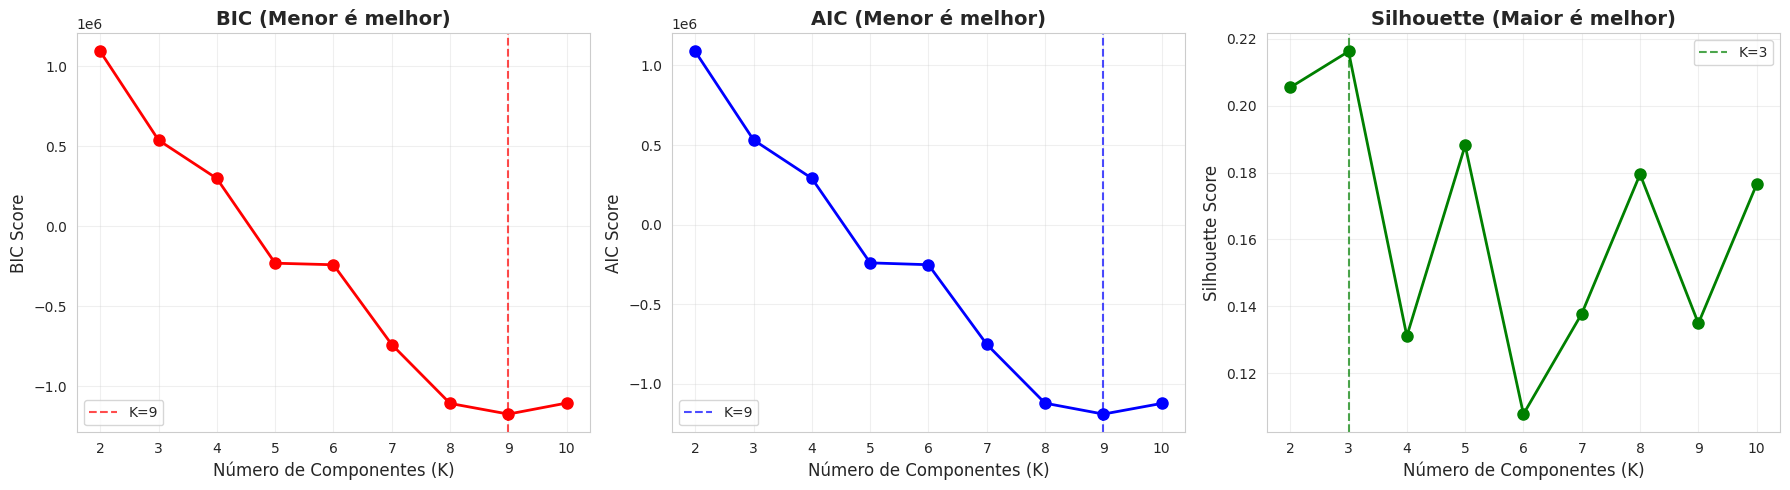


✓ Gráfico salvo: gmm_selection_metrics.png


In [34]:
# Visualizar critérios de seleção
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BIC
axes[0].plot(K_range, bic_scores, 'ro-', linewidth=2, markersize=8)
axes[0].axvline(best_k_bic, color='red', linestyle='--', alpha=0.7, label=f'K={best_k_bic}')
axes[0].set_xlabel('Número de Componentes (K)', fontsize=12)
axes[0].set_ylabel('BIC Score', fontsize=12)
axes[0].set_title('BIC (Menor é melhor)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)
axes[0].legend()

# AIC
axes[1].plot(K_range, aic_scores, 'bo-', linewidth=2, markersize=8)
axes[1].axvline(best_k_aic, color='blue', linestyle='--', alpha=0.7, label=f'K={best_k_aic}')
axes[1].set_xlabel('Número de Componentes (K)', fontsize=12)
axes[1].set_ylabel('AIC Score', fontsize=12)
axes[1].set_title('AIC (Menor é melhor)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)
axes[1].legend()

# Silhouette
axes[2].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[2].axvline(best_k_sil, color='green', linestyle='--', alpha=0.7, label=f'K={best_k_sil}')
axes[2].set_xlabel('Número de Componentes (K)', fontsize=12)
axes[2].set_ylabel('Silhouette Score', fontsize=12)
axes[2].set_title('Silhouette (Maior é melhor)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(K_range)
axes[2].legend()

plt.tight_layout()
# plt.savefig('gmm_selection_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo: gmm_selection_metrics.png")

In [35]:
# Escolher K ótimo (usar BIC como critério principal)
K_optimal = 7
print(f"\n K ÓTIMO ESCOLHIDO: {K_optimal} (baseado no BIC)")


 K ÓTIMO ESCOLHIDO: 7 (baseado no BIC)


## 7. Aplicação do GMM com K Ótimo

Treinar o modelo final e extrair:
- **Labels**: cluster predominante de cada OP (hard clustering)
- **Probabilidades**: probabilidade de pertencer a cada cluster (soft clustering)

In [36]:
%%time
# Treinar GMM final
print(f"Treinando GMM com K={K_optimal}...")
gmm_final = GaussianMixture(
    n_components=K_optimal,
    covariance_type='full',
    random_state=42,
    n_init=10,
    max_iter=100
)
gmm_final.fit(X_final)

print(f"\n✓ Modelo GMM treinado com sucesso!")
print(f"  Convergiu: {gmm_final.converged_}")
print(f"  Iterações: {gmm_final.n_iter_}")
print(f"  Log-likelihood: {gmm_final.score(X_final) * len(X_final):,.0f}")

Treinando GMM com K=7...

✓ Modelo GMM treinado com sucesso!
  Convergiu: True
  Iterações: 12
  Log-likelihood: 377,738
CPU times: user 4min 48s, sys: 412 ms, total: 4min 49s
Wall time: 40.8 s


In [39]:
df_flexo_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33550 entries, 0 to 33552
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CD_OP                           33550 non-null  string 
 1   QT_PRODUZIDA                    33550 non-null  float64
 2   QT_CHAPASALIMENTADAS            33550 non-null  float64
 3   VL_DURACAO_PRODUCAO             33550 non-null  float64
 4   QT_PROGRAMADA                   33550 non-null  float64
 5   VL_DURACAO_PARADAS              33550 non-null  float64
 6   QT_PARADAS                      33550 non-null  float64
 7   CAT_ESPELHO                     33550 non-null  string 
 8   CD_FACA                         33550 non-null  string 
 9   CAT_FILME                       33550 non-null  string 
 10  CD_ITEM                         33550 non-null  string 
 11  CD_PEDIDO                       33550 non-null  string 
 12  FL_CONTROLE_ESPECIAL_IMPRESSAO  33550

In [40]:
df_flexo_pedidos.shape

(33550, 64)

In [41]:
# Obter labels e probabilidades
cluster_labels = gmm_final.predict(X_final)
cluster_probs = gmm_final.predict_proba(X_final)

# Adicionar ao dataframe original
df_flexo_pedidos['CLUSTER_PRODUTO'] = cluster_labels

# Adicionar probabilidades de cada cluster
for k in range(K_optimal):
    df_flexo_pedidos[f'PROB_CLUSTER_{k}'] = cluster_probs[:, k]

# Calcular entropia (incerteza do clustering)
entropy = -np.sum(cluster_probs * np.log(cluster_probs + 1e-10), axis=1)
df_flexo_pedidos['CLUSTER_ENTROPY'] = entropy

print("\nDistribuição dos Clusters:")
print(df_flexo_pedidos['CLUSTER_PRODUTO'].value_counts().sort_index())

print(f"\nEntropia média: {entropy.mean():.4f}")
print(f"  Baixa entropia (<0.5): {(entropy < 0.5).sum():,} OPs ({(entropy < 0.5).sum()/len(entropy)*100:.1f}%)")
print(f"  Alta entropia (>1.0): {(entropy > 1.0).sum():,} OPs ({(entropy > 1.0).sum()/len(entropy)*100:.1f}%)")


Distribuição dos Clusters:
CLUSTER_PRODUTO
0     1093
1    10106
2     5562
3    14210
4        3
5      105
6     2471
Name: count, dtype: int64

Entropia média: 0.0015
  Baixa entropia (<0.5): 33,509 OPs (99.9%)
  Alta entropia (>1.0): 0 OPs (0.0%)


/tmp/ipykernel_997671/3313670850.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flexo_pedidos['CLUSTER_PRODUTO'] = cluster_labels
/tmp/ipykernel_997671/3313670850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flexo_pedidos[f'PROB_CLUSTER_{k}'] = cluster_probs[:, k]
/tmp/ipykernel_997671/3313670850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

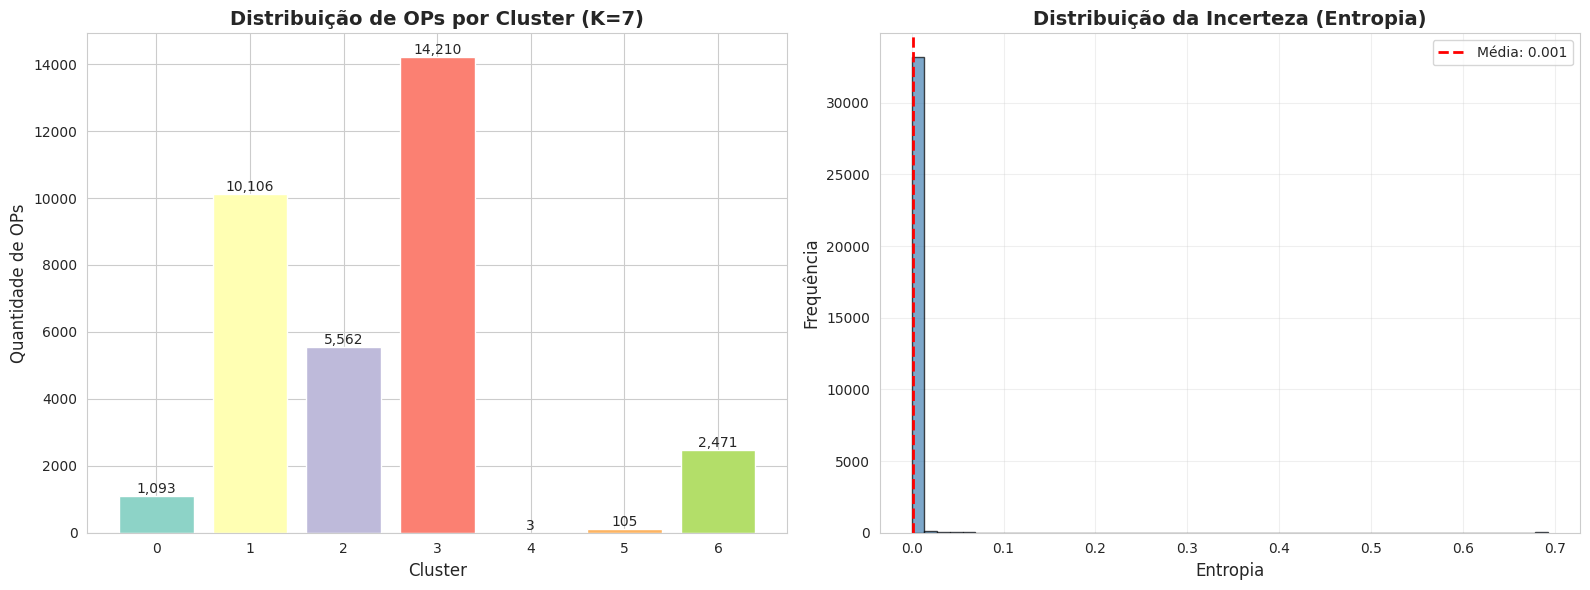


✓ Gráfico salvo: gmm_distribution.png


In [42]:
# Visualização da distribuição
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribuição de OPs por cluster
cluster_counts = df_flexo_pedidos['CLUSTER_PRODUTO'].value_counts().sort_index()
bars = ax1.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.Set3(range(K_optimal)))
ax1.set_xlabel('Cluster', fontsize=12)
ax1.set_ylabel('Quantidade de OPs', fontsize=12)
ax1.set_title(f'Distribuição de OPs por Cluster (K={K_optimal})', fontsize=14, fontweight='bold')
ax1.set_xticks(range(K_optimal))

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10)

# Histograma de entropia
ax2.hist(entropy, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(entropy.mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {entropy.mean():.3f}')
ax2.set_xlabel('Entropia', fontsize=12)
ax2.set_ylabel('Frequência', fontsize=12)
ax2.set_title('Distribuição da Incerteza (Entropia)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gmm_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo: gmm_distribution.png")

In [43]:
# Salvar modelos
joblib.dump(gmm_final, 'gmm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca_reducer, 'pca_reducer.pkl')

print("\n✓ Modelos salvos:")
print("  • gmm_model.pkl - Modelo GMM treinado")
print("  • scaler.pkl - StandardScaler para normalização")
print("  • pca_reducer.pkl - PCA para redução de dimensionalidade")


✓ Modelos salvos:
  • gmm_model.pkl - Modelo GMM treinado
  • scaler.pkl - StandardScaler para normalização
  • pca_reducer.pkl - PCA para redução de dimensionalidade


## 8. Análise de Perfil dos Clusters

Analisar as características predominantes de cada cluster.

In [44]:
df_flexo_pedidos.columns

Index(['CD_OP', 'QT_PRODUZIDA', 'QT_CHAPASALIMENTADAS', 'VL_DURACAO_PRODUCAO',
       'QT_PROGRAMADA', 'VL_DURACAO_PARADAS', 'QT_PARADAS', 'CAT_ESPELHO',
       'CD_FACA', 'CAT_FILME', 'CD_ITEM', 'CD_PEDIDO',
       'FL_CONTROLE_ESPECIAL_IMPRESSAO', 'FL_TESTE_EXIGELAUDO', 'FL_REFILADO',
       'FL_RESINAINTERNA', 'PERC_VAR_PEDIDA', 'QT_ARRANJO', 'VL_COBBINTMAXIMO',
       'QT_NRCORES', 'QT_PEDIDA', 'CAT_COMPOSICAO', 'TX_TIPOABNT',
       'VL_ALTURAINTERNA', 'VL_AREALIQUIDAPECA', 'VL_COLUNAMINIMO',
       'VL_COMPPECA', 'VL_COMPRESSAO', 'VL_COMPRIMENTO',
       'VL_COMPRIMENTOINTERNO', 'VL_GRAMATURA', 'VL_LAP', 'FL_LAP_INTERNO',
       'FL_LAP_NO_COMPR', 'VL_LARGPECA', 'VL_LARGURA', 'VL_LARGURAINTERNA',
       'VL_MULTCOMP', 'VL_MULTLARG', 'VL_PESOCAIXA', 'VL_PESOPECA',
       'VL_REFILOCOMPRIMENTO', 'VL_REFILOLARGURA', 'VL_REFUGOCLIENTE',
       'VL_VINCOCOMP1', 'VL_VINCOCOMP2', 'VL_VINCOCOMP3', 'VL_VINCOCOMP4',
       'VL_VINCOCOMP5', 'VL_VINCOLARG1', 'VL_VINCOLARG2', 'VL_VINCOLARG3',

In [45]:
# Features principais para análise
features_perfil = [
    "VL_COMPRIMENTO",
    "VL_LARGURA",
    "VL_ALTURAINTERNA",
    "VL_GRAMATURA",
    "QT_NRCORES",
    "VL_AREALIQUIDAPECA",
    "VL_MULTCOMP",
    "VL_MULTLARG",
    "PECAS_POR_CHAPA",
    "VL_VINCOS_TOTAL_MM",
    "VL_CONSUMO_COR_TOTAL",
    "VOLUME_INTERNO",
    "AREA_CHAPA",
    "REFILO_TOTAL",
]

# Calcular perfil médio
cluster_profiles_mean = df_flexo_pedidos.groupby('CLUSTER_PRODUTO')[features_perfil].mean()

print("Perfil dos Clusters (médias):")
print("="*100)
print(cluster_profiles_mean.round(2))

# Salvar
cluster_profiles_mean.to_csv('gmm_cluster_profiles.csv')
print("\n✓ Perfil salvo: gmm_cluster_profiles.csv")

Perfil dos Clusters (médias):
                 VL_COMPRIMENTO  VL_LARGURA  VL_ALTURAINTERNA  VL_GRAMATURA  \
CLUSTER_PRODUTO                                                               
0                       1462.38      667.23            355.52        454.83   
1                       1313.23      449.25            195.03        665.06   
2                       1231.82      398.92            156.05        525.66   
3                       1394.00      535.68            275.18        377.09   
4                       1259.00      599.00            350.00          0.00   
5                       1393.64      625.40            437.22        193.71   
6                       1388.01      528.91            250.89        405.53   

                 QT_NRCORES  VL_AREALIQUIDAPECA  VL_MULTCOMP  VL_MULTLARG  \
CLUSTER_PRODUTO                                                             
0                      2.30                0.99          1.0          1.0   
1                      1.03

In [46]:
# Análise de categóricas (que foram excluídas do clustering)
print("\n" + "="*100)
print("Características Categóricas por Cluster:")
print("="*100)

categoricas_analise = ['CAT_COMPOSICAO', 'CAT_ESPELHO', 'CAT_FILME', 'TX_TIPOABNT']

for col in categoricas_analise:
    if col in df_flexo_pedidos.columns:
        print(f"\n{col}:")
        crosstab = pd.crosstab(
            df_flexo_pedidos['CLUSTER_PRODUTO'], 
            df_flexo_pedidos[col], 
            normalize='index'
        ) * 100
        print(crosstab.round(1))


Características Categóricas por Cluster:

CAT_COMPOSICAO:
CAT_COMPOSICAO   A1-B  A1-D  A1-DC  A10-B  A10-C  A10D-B  A10S-B  A10S-C  \
CLUSTER_PRODUTO                                                            
0                 5.6   0.4    0.0    8.3    2.5     0.0     0.2     2.2   
1                 0.0   0.0    0.4    3.3    9.6     0.1     0.0     8.0   
2                 2.8   4.1    2.2   10.4   16.9     0.0     0.0     2.4   
3                15.4   3.9    3.4    3.5    6.3     0.0     0.0     4.1   
4                 0.0   0.0    0.0    0.0    0.0     0.0     0.0     0.0   
5                 2.9   0.0    4.8    0.0    1.0     0.0     0.0     4.8   
6                 9.8   1.3    4.4    2.8   10.6     0.0     0.0     5.1   

CAT_COMPOSICAO   A12-B  A12-C  A15-B  A15-C  A18-C  A2-B  A2-DC  A2K-DC  \
CLUSTER_PRODUTO                                                           
0                  0.0   10.1    0.0    7.7    0.0   5.3    0.0     0.0   
1                  2.9    1.6  

In [47]:
# Resumo interpretativo
print("\n" + "="*100)
print("RESUMO INTERPRETATIVO DOS CLUSTERS")
print("="*100)

for cluster_id in range(K_optimal):
    cluster_data = df_flexo_pedidos[df_flexo_pedidos['CLUSTER_PRODUTO'] == cluster_id]
    n_ops = len(cluster_data)
    
    print(f"\n🔹 CLUSTER {cluster_id} ({n_ops:,} OPs - {n_ops/len(df_flexo_pedidos)*100:.1f}%)")
    print("-" * 80)
    
    # Dimensões médias
    comp_med = cluster_data['VL_COMPRIMENTO'].mean()
    larg_med = cluster_data['VL_LARGURA'].mean()
    alt_med = cluster_data['VL_ALTURAINTERNA'].mean()
    print(f"  Dimensões médias: {comp_med:.0f} x {larg_med:.0f} x {alt_med:.0f} mm")
    
    # Gramatura e área
    gram_med = cluster_data['VL_GRAMATURA'].mean()
    area_med = cluster_data['VL_AREALIQUIDAPECA'].mean()
    print(f"  Gramatura média: {gram_med:.0f} g/m²")
    print(f"  Área líquida: {area_med:.3f} m²")
    
    # Cores
    cores_med = cluster_data['QT_NRCORES'].mean()
    consumo_cor = cluster_data['VL_CONSUMO_COR_TOTAL'].mean()
    print(f"  Cores: {cores_med:.1f} cores em média, consumo: {consumo_cor:.0f}")
    
    # Aproveitamento
    pecas_chapa = cluster_data['PECAS_POR_CHAPA'].mean()
    print(f"  Aproveitamento: {pecas_chapa:.1f} peças/chapa em média")
    
    # Composição predominante
    composicao_pred = cluster_data['CAT_COMPOSICAO'].mode()
    if len(composicao_pred) > 0:
        print(f"  Composição predominante: {composicao_pred.iloc[0]}")
    
    # Certeza média do cluster
    prob_media = cluster_data[f'PROB_CLUSTER_{cluster_id}'].mean()
    print(f"  Probabilidade média de pertencimento: {prob_media:.2%}")


RESUMO INTERPRETATIVO DOS CLUSTERS

🔹 CLUSTER 0 (1,093 OPs - 3.3%)
--------------------------------------------------------------------------------
  Dimensões médias: 1462 x 667 x 356 mm
  Gramatura média: 455 g/m²
  Área líquida: 0.988 m²
  Cores: 2.3 cores em média, consumo: 2339
  Aproveitamento: 1.0 peças/chapa em média
  Composição predominante: B1-B
  Probabilidade média de pertencimento: 100.00%

🔹 CLUSTER 1 (10,106 OPs - 30.1%)
--------------------------------------------------------------------------------
  Dimensões médias: 1313 x 449 x 195 mm
  Gramatura média: 665 g/m²
  Área líquida: 0.587 m²
  Cores: 1.0 cores em média, consumo: 425
  Aproveitamento: 1.0 peças/chapa em média
  Composição predominante: DA10-C
  Probabilidade média de pertencimento: 99.99%

🔹 CLUSTER 2 (5,562 OPs - 16.6%)
--------------------------------------------------------------------------------
  Dimensões médias: 1232 x 399 x 156 mm
  Gramatura média: 526 g/m²
  Área líquida: 0.483 m²
  Cores: 1.

## 9. Visualizações dos Clusters

### 9.1 PCA - Visualização em 2D

In [48]:
# PCA para visualização em 2D
pca_viz = PCA(n_components=2, random_state=42)
X_pca_2d = pca_viz.fit_transform(X_final)

print(f"Variância explicada pelos 2 primeiros PCs:")
print(f"  PC1: {pca_viz.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca_viz.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {pca_viz.explained_variance_ratio_.sum()*100:.2f}%")

Variância explicada pelos 2 primeiros PCs:
  PC1: 16.45%
  PC2: 9.80%
  Total: 26.25%


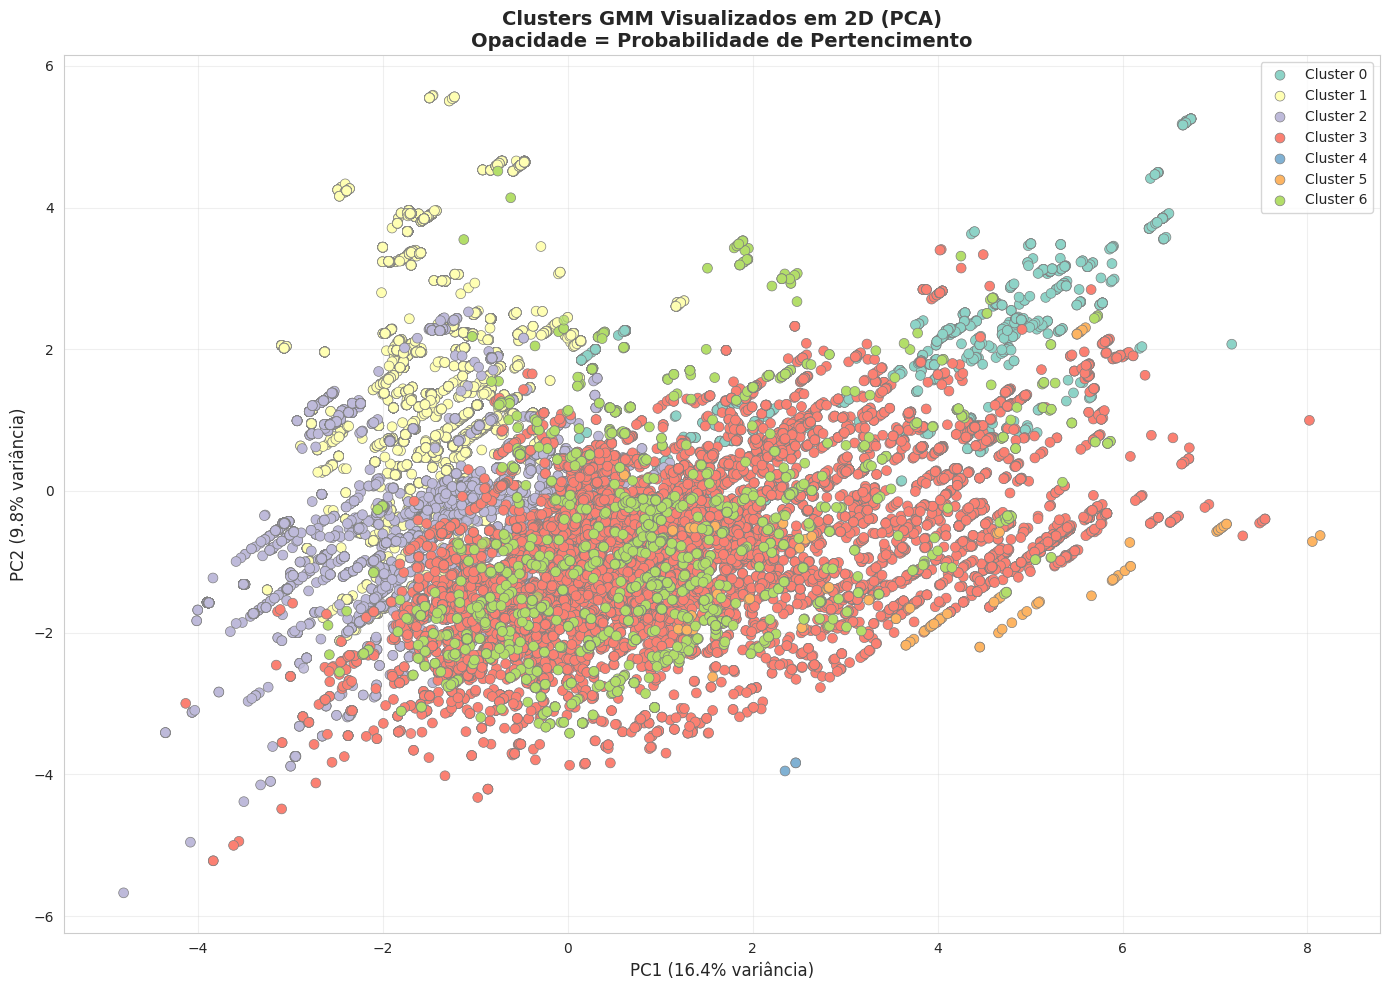


✓ Gráfico salvo: gmm_clusters_pca_2d.png


In [49]:
# Visualizar clusters com intensidade baseada em probabilidade
fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.Set3(range(K_optimal))
for cluster_id in range(K_optimal):
    mask = cluster_labels == cluster_id
    
    # Usar probabilidade como alpha (transparência)
    probs = cluster_probs[mask, cluster_id]
    
    scatter = ax.scatter(
        X_pca_2d[mask, 0], 
        X_pca_2d[mask, 1], 
        c=[colors[cluster_id]], 
        alpha=probs * 0.8 + 0.2,  # Alpha proporcional à probabilidade
        s=50,
        edgecolors='gray', 
        linewidth=0.5,
        label=f'Cluster {cluster_id}'
    )

ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variância)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variância)', fontsize=12)
ax.set_title('Clusters GMM Visualizados em 2D (PCA)\nOpacidade = Probabilidade de Pertencimento', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gmm_clusters_pca_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráfico salvo: gmm_clusters_pca_2d.png")

### 9.2 Heatmap - Perfil dos Clusters

Valores normalizados (primeiros clusters):
                 VL_COMPRIMENTO  VL_LARGURA  VL_ALTURAINTERNA  VL_GRAMATURA  \
CLUSTER_PRODUTO                                                               
0                      1.000000    1.000000          0.709424      0.683902   
1                      0.353112    0.187585          0.138652      1.000000   
2                      0.000000    0.000000          0.000000      0.790406   
3                      0.703405    0.509734          0.423700      0.567000   
4                      0.117904    0.745716          0.689803      0.000000   

                 QT_NRCORES  VL_AREALIQUIDAPECA  VL_CONSUMO_COR_TOTAL  \
CLUSTER_PRODUTO                                                         
0                  0.643736            1.000000              0.320760   
1                  0.000000            0.204860              0.000964   
2                  0.337555            0.000000              0.000000   
3                  0.467574           

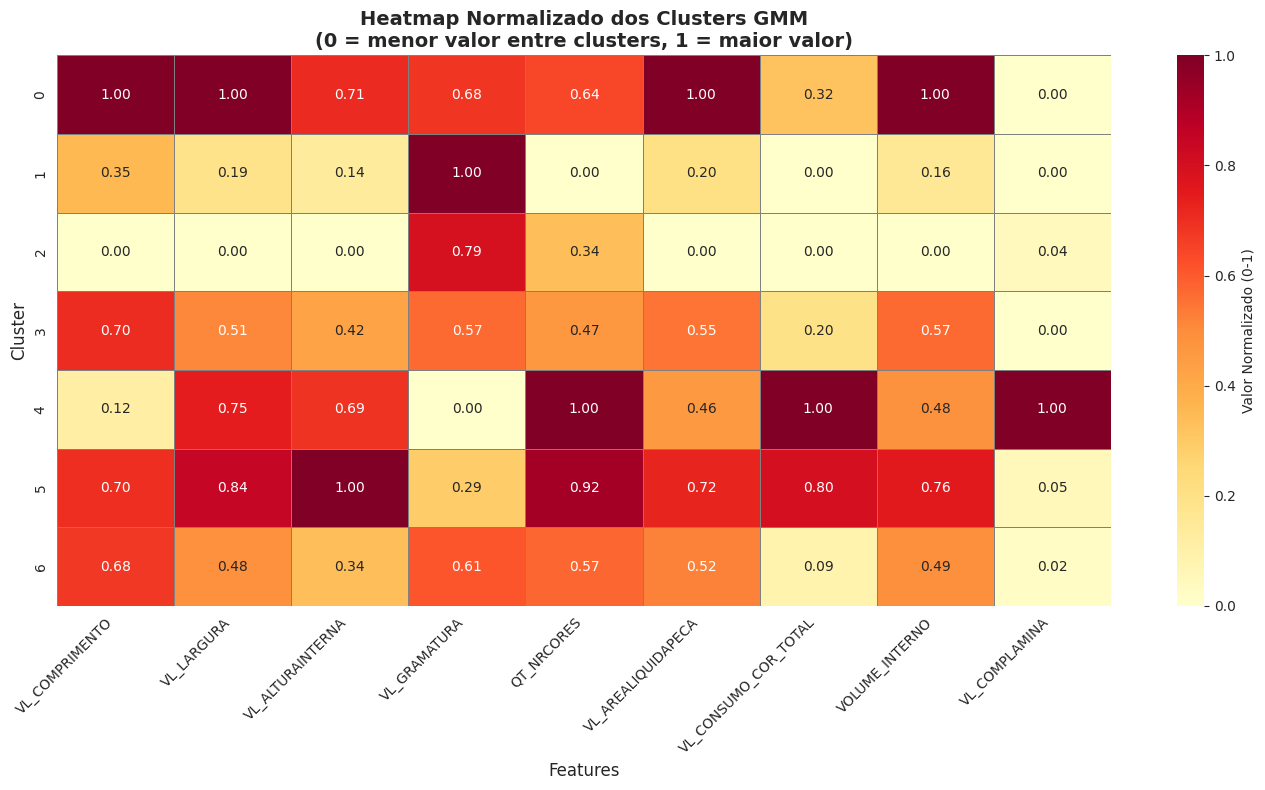


✓ Gráfico salvo: gmm_cluster_heatmap.png


In [50]:
# Heatmap normalizado - CORRIGIDO
features_heatmap = [
    "VL_COMPRIMENTO",
    "VL_LARGURA",
    "VL_ALTURAINTERNA",
    "VL_GRAMATURA",
    "QT_NRCORES",
    "VL_AREALIQUIDAPECA",
    "VL_CONSUMO_COR_TOTAL",
    "VOLUME_INTERNO",
    "VL_COMPLAMINA",
]

cluster_means = df_flexo_pedidos.groupby("CLUSTER_PRODUTO")[features_heatmap].mean()

# CORREÇÃO: Normalizar POR COLUNA (cada feature entre 0-1)
minmax = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(
    minmax.fit_transform(cluster_means),  # ← SEM .T (transpor)
    index=cluster_means.index,
    columns=cluster_means.columns,
)

# Verificar se deu certo
print("Valores normalizados (primeiros clusters):")
print(cluster_means_normalized.head())
print(f"\nMin por coluna: {cluster_means_normalized.min()}")
print(f"Max por coluna: {cluster_means_normalized.max()}")

fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    cluster_means_normalized,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={"label": "Valor Normalizado (0-1)"},
    linewidths=0.5,
    linecolor="gray",
    ax=ax,
)

ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)
ax.set_title(
    "Heatmap Normalizado dos Clusters GMM\n(0 = menor valor entre clusters, 1 = maior valor)",
    fontsize=14,
    fontweight="bold",
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("gmm_cluster_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✓ Gráfico salvo: gmm_cluster_heatmap.png")


In [159]:
df_flexo_pedidos.VL_COMPRIMENTO.min()

np.float64(679.0)

In [160]:
cluster_means_normalized

,VL_COMPRIMENTO,VL_LARGURA,VL_ALTURAINTERNA,VL_GRAMATURA,QT_NRCORES,VL_AREALIQUIDAPECA,VL_CONSUMO_COR_TOTAL,VOLUME_INTERNO,VL_COMPLAMINA
CLUSTER_PRODUTO,,,,,,,,,
0,1.000000,0.738273,0.872361,0.444307,0.537083,0.858814,0.336045,0.897154,0.031207
1,0.802140,1.000000,1.000000,0.706961,0.632088,1.000000,0.322298,1.000000,0.017749
2,0.392962,0.082505,0.107593,1.000000,0.000000,0.168535,0.006015,0.118634,0.048745
3,0.178824,0.142725,0.180938,0.892369,0.219137,0.149624,0.018949,0.124010,0.017628
4,0.123462,0.734664,0.971643,0.000000,1.000000,0.446368,1.000000,0.471546,1.000000
5,0.579361,0.465542,0.514104,0.570455,0.495995,0.530847,0.088611,0.531441,0.000000
6,0.000000,0.000000,0.000000,0.847405,0.134675,0.000000,0.000000,0.000000,0.086009


### 9.3 Análise de Soft Clustering (Probabilidades)

In [51]:
# Encontrar exemplos de OPs com alta incerteza
high_entropy = df_flexo_pedidos.nlargest(10, 'CLUSTER_ENTROPY')

print("Top 10 OPs com MAIOR incerteza (pertencem a múltiplos clusters):")
print("="*100)

for idx, row in high_entropy.iterrows():
    print(f"\nCD_OP: {row['CD_OP']} | Cluster: {row['CLUSTER_PRODUTO']} | Entropia: {row['CLUSTER_ENTROPY']:.3f}")
    print("Probabilidades:")
    for k in range(K_optimal):
        prob = row[f'PROB_CLUSTER_{k}']
        print(f"  Cluster {k}: {prob:.1%}")

Top 10 OPs com MAIOR incerteza (pertencem a múltiplos clusters):

CD_OP: 678404-1/850380 | Cluster: 2 | Entropia: 0.693
Probabilidades:
  Cluster 0: 0.0%
  Cluster 1: 0.0%
  Cluster 2: 51.4%
  Cluster 3: 0.0%
  Cluster 4: 0.0%
  Cluster 5: 0.0%
  Cluster 6: 48.6%

CD_OP: 682605-1/850380 | Cluster: 2 | Entropia: 0.693
Probabilidades:
  Cluster 0: 0.0%
  Cluster 1: 0.0%
  Cluster 2: 51.4%
  Cluster 3: 0.0%
  Cluster 4: 0.0%
  Cluster 5: 0.0%
  Cluster 6: 48.6%

CD_OP: 696138-1/850380 | Cluster: 2 | Entropia: 0.693
Probabilidades:
  Cluster 0: 0.0%
  Cluster 1: 0.0%
  Cluster 2: 51.4%
  Cluster 3: 0.0%
  Cluster 4: 0.0%
  Cluster 5: 0.0%
  Cluster 6: 48.6%

CD_OP: 700867-2/850380 | Cluster: 2 | Entropia: 0.693
Probabilidades:
  Cluster 0: 0.0%
  Cluster 1: 0.0%
  Cluster 2: 51.4%
  Cluster 3: 0.0%
  Cluster 4: 0.0%
  Cluster 5: 0.0%
  Cluster 6: 48.6%

CD_OP: 706775-1/850380 | Cluster: 2 | Entropia: 0.693
Probabilidades:
  Cluster 0: 0.0%
  Cluster 1: 0.0%
  Cluster 2: 51.4%
  Cluster 3: 

In [60]:
df = df_flexo_pedidos.copy()
df = df[df["VL_DURACAO_PRODUCAO"] > 0]  # evita div/0
df["PROD_HORA"] = df["QT_PRODUZIDA"] / (df["VL_DURACAO_PRODUCAO"] / 60)

limiar = df["PROD_HORA"].quantile(0.6)  # ex.: mediana
df["y_produtivo"] = (df["PROD_HORA"] >= limiar).astype(int)


In [61]:
limiar


np.float64(6427.291053990346)

In [62]:
df_flexo_pedidos

,CD_OP,QT_PRODUZIDA,QT_CHAPASALIMENTADAS,VL_DURACAO_PRODUCAO,QT_PROGRAMADA,VL_DURACAO_PARADAS,QT_PARADAS,CAT_ESPELHO,CD_FACA,CAT_FILME,CD_ITEM,CD_PEDIDO,FL_CONTROLE_ESPECIAL_IMPRESSAO,FL_TESTE_EXIGELAUDO,FL_REFILADO,FL_RESINAINTERNA,PERC_VAR_PEDIDA,QT_ARRANJO,VL_COBBINTMAXIMO,QT_NRCORES,QT_PEDIDA,CAT_COMPOSICAO,TX_TIPOABNT,VL_ALTURAINTERNA,VL_AREALIQUIDAPECA,VL_COLUNAMINIMO,VL_COMPPECA,VL_COMPRESSAO,VL_COMPRIMENTO,VL_COMPRIMENTOINTERNO,VL_GRAMATURA,VL_LAP,FL_LAP_INTERNO,FL_LAP_NO_COMPR,VL_LARGPECA,VL_LARGURA,VL_LARGURAINTERNA,VL_MULTCOMP,VL_MULTLARG,VL_PESOCAIXA,VL_PESOPECA,VL_REFILOCOMPRIMENTO,VL_REFILOLARGURA,VL_REFUGOCLIENTE,VL_VINCOCOMP1,VL_VINCOCOMP2,VL_VINCOCOMP3,VL_VINCOCOMP4,VL_VINCOCOMP5,VL_VINCOLARG1,VL_VINCOLARG2,VL_VINCOLARG3,VL_CONSUMO_COR_TOTAL,FL_PROLONGLAP,VL_VINCOS_TOTAL_MM,RAZAO_CHAPA_COMP_LARG,RAZAO_PECA_COMP_LARG,VOLUME_INTERNO,VL_COMPLAMINA,RAZAO_COMP_LARG,RAZAO_INTERNA,AREA_CHAPA,PECAS_POR_CHAPA,REFILO_TOTAL,CLUSTER_PRODUTO,PROB_CLUSTER_0,PROB_CLUSTER_1,PROB_CLUSTER_2,PROB_CLUSTER_3,PROB_CLUSTER_4,PROB_CLUSTER_5,PROB_CLUSTER_6,CLUSTER_ENTROPY
0,639837-3/795630,3360.0,3372.0,63.0,3378.0,30.0,2.0,1,-1,1,795630,639837-3,0,1,1,0,2.97619,1,30.0,1,3360.0,A4-DC,CN,150.0,0.698480,0.0,1579.0,754.0,1579.0,482.0,997.0,30.0,1,0,452.0,452.0,282.0,1.0,1.0,700.0,0.0,0.0,0.0,2.133646,30.0,288.0,488.0,288.0,485.0,145.0,162.0,145.0,111.0,1.0,2031.0,3.493363,3.493363,20388600.0,0.0,3.493363,1.709220,713708.0,1.0,0.0,1,0.0,1.000000e+00,6.648365e-73,0.0,0.0,0.0,3.133903e-39,-1.000000e-10
1,640041-1/779500,7200.0,7248.0,63.0,7500.0,5.0,3.0,1,-1,1,779500,640041-1,0,1,1,0,3.00000,1,30.0,2,7500.0,B3-DC,CN,165.0,0.628333,10.0,1379.0,0.0,1379.0,382.0,843.0,30.0,1,0,467.0,467.0,282.0,1.0,1.0,526.0,0.0,0.0,0.0,2.431703,30.0,288.0,388.0,288.0,385.0,145.0,177.0,145.0,524.0,0.0,1846.0,2.952891,2.952891,17774460.0,0.0,2.952891,1.354610,643993.0,1.0,0.0,3,0.0,1.566742e-18,3.907186e-19,1.0,0.0,0.0,1.812076e-20,-9.999996e-11
2,640477-2/841380,3640.0,3652.0,43.0,3663.0,18.0,3.0,1,-1,1,841380,640477-2,0,1,1,0,3.00000,1,30.0,1,3600.0,A15-C,CNAR,214.0,0.560672,9.0,1252.0,0.0,1252.0,372.0,624.0,30.0,1,0,458.0,458.0,232.0,1.0,1.0,350.0,0.0,0.0,0.0,2.222470,30.0,236.0,376.0,236.0,374.0,118.0,222.0,118.0,476.0,1.0,1710.0,2.733624,2.733624,18469056.0,0.0,2.733624,1.603448,573416.0,1.0,0.0,1,0.0,1.000000e+00,1.700872e-09,0.0,0.0,0.0,2.047751e-12,3.589708e-08
3,640579-2/792980,4800.0,4800.0,38.0,4800.0,10.0,2.0,1,-1,1,792980,640579-2,0,1,1,0,3.00000,1,45.0,1,4800.0,A3-DC,CN,223.0,0.709496,10.0,1379.0,0.0,1379.0,382.0,840.0,30.0,1,0,525.0,525.0,282.0,1.0,1.0,595.0,0.0,0.0,0.0,2.000000,30.0,288.0,388.0,288.0,385.0,145.0,235.0,145.0,547.0,0.0,1904.0,2.626667,2.626667,24022452.0,0.0,2.626667,1.354610,723975.0,1.0,0.0,3,0.0,3.200642e-16,1.232211e-21,1.0,0.0,0.0,3.578683e-20,-9.999264e-11
4,640836-1/854630,3093.0,3136.0,46.0,3108.0,27.0,5.0,1,-1,1,854630,640836-1,0,1,1,0,3.00000,1,30.0,1,3000.0,B3-DC,CN,165.0,0.628333,10.0,1379.0,0.0,1379.0,382.0,843.0,30.0,1,0,467.0,467.0,282.0,1.0,1.0,530.0,0.0,0.0,0.0,2.431703,30.0,288.0,388.0,288.0,385.0,145.0,177.0,145.0,0.0,0.0,1846.0,2.952891,2.952891,17774460.0,0.0,2.952891,1.354610,643993.0,1.0,0.0,3,0.0,6.139495e-16,1.908461e-20,1.0,0.0,0.0,7.202404e-21,-9.998587e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33548,729482-1/656160,18900.0,18900.0,244.0,18501.0,0.0,0.0,1,-1,1,656160,729482-1,0,1,1,0,5.00000,1,30.0,1,18900.0,A12-C,CN,200.0,0.668883,8.0,1380.0,372.0,1380.0,384.0,577.0,30.0,1,1,496.0,496.0,284.0,1.0,1.0,388.0,385.0,0.0,0.0,2.278680,30.0,388.0,288.0,388.0,286.0,144.0,208.0,144.0,635.0,1.0,1876.0,2.782258,2.782258,21811200.0,0.0,2.782258,1.352113,684480.0,1.0,0.0,1,0.0,1.000000e+00,2.458449e-13,0.0,0.0,0.0,4.733446e-20,-9.409380e-11
33549,729510-1/880950,

In [87]:
df_cluster.columns

Index(['CAT_ESPELHO', 'CAT_FILME', 'FL_CONTROLE_ESPECIAL_IMPRESSAO',
       'FL_TESTE_EXIGELAUDO', 'FL_RESINAINTERNA', 'PERC_VAR_PEDIDA',
       'VL_COBBINTMAXIMO', 'QT_NRCORES', 'QT_PEDIDA', 'VL_COLUNAMINIMO',
       'VL_COMPPECA', 'VL_COMPRESSAO', 'VL_GRAMATURA', 'VL_LAP',
       'FL_LAP_INTERNO', 'FL_LAP_NO_COMPR', 'VL_LARGPECA', 'VL_REFILOLARGURA',
       'VL_REFUGOCLIENTE', 'VL_CONSUMO_COR_TOTAL', 'FL_PROLONGLAP',
       'VOLUME_INTERNO', 'VL_COMPLAMINA', 'RAZAO_COMP_LARG', 'RAZAO_INTERNA'],
      dtype='object')

In [101]:
features_produto = [
 'FL_CONTROLE_ESPECIAL_IMPRESSAO',
       'FL_TESTE_EXIGELAUDO', 'FL_RESINAINTERNA', 'PERC_VAR_PEDIDA',
       'VL_COBBINTMAXIMO', 'QT_NRCORES', 'QT_PEDIDA', 'VL_COLUNAMINIMO',
       'VL_COMPPECA', 'VL_COMPRESSAO', 'VL_GRAMATURA', 'VL_LAP',
       'FL_LAP_INTERNO', 'FL_LAP_NO_COMPR', 'VL_LARGPECA', 'VL_REFILOLARGURA',
       'VL_REFUGOCLIENTE', 'VL_CONSUMO_COR_TOTAL', 'FL_PROLONGLAP',
       'VOLUME_INTERNO', 'VL_COMPLAMINA', 'RAZAO_COMP_LARG', 'RAZAO_INTERNA'
]

prob_cols = [f"PROB_CLUSTER_{k}" for k in range(7)]
#cols_X = features_produto + ["CLUSTER_PRODUTO"] + prob_cols
cols_X = features_produto + prob_cols

df_model = df.dropna(subset=cols_X + ["y_produtivo"])
X = df_model[cols_X]
y = df_model["y_produtivo"]


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC AUC: 0.842287010364079
              precision    recall  f1-score   support

           0       0.72      0.93      0.81      4026
           1       0.82      0.44      0.58      2684

    accuracy                           0.74      6710
   macro avg       0.77      0.69      0.69      6710
weighted avg       0.76      0.74      0.72      6710



In [105]:
from sklearn.inspection import permutation_importance
import pandas as pd

r = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
importancia_global = pd.Series(r.importances_mean, index=X_test.columns).sort_values(
    ascending=False
)
print(importancia_global.head(20))


QT_PEDIDA               0.122951
VL_COMPPECA             0.014829
VOLUME_INTERNO          0.011416
VL_COMPRESSAO           0.009031
VL_LARGPECA             0.007213
VL_CONSUMO_COR_TOTAL    0.003949
FL_RESINAINTERNA        0.003264
VL_GRAMATURA            0.003204
VL_COMPLAMINA           0.003145
RAZAO_COMP_LARG         0.002891
VL_REFUGOCLIENTE        0.002593
PROB_CLUSTER_1          0.002593
QT_NRCORES              0.002474
RAZAO_INTERNA           0.002265
VL_COLUNAMINIMO         0.002086
PROB_CLUSTER_6          0.001550
PERC_VAR_PEDIDA         0.001252
PROB_CLUSTER_2          0.000611
PROB_CLUSTER_0          0.000253
PROB_CLUSTER_3          0.000224
dtype: float64


In [106]:
import shap

# amostra de fundo para o SHAP (pode usar X_train todo ou um sample)
explainer = shap.Explainer(clf, X_train)

shap_values = explainer(X_test)  # mesma ordem de X_test
shap_array = shap_values.values  # shape: [n_amostras, n_features]


def top_k_features_por_op(X_subset, shap_vals, k=5):
    resultados = []
    for i, idx in enumerate(X_subset.index):
        contrib = pd.DataFrame(
            {
                "feature": X_subset.columns,
                "shap_value": shap_vals[i],
            }
        )
        contrib["impacto_abs"] = contrib["shap_value"].abs()
        topk = contrib.sort_values("impacto_abs", ascending=False).head(k)

        resultados.append(
            {
                "CD_OP": df_model.loc[idx, "CD_OP"],
                "prob_produtivo": clf.predict_proba(X_subset.iloc[[i]])[0, 1],
                "classe_prevista": int(clf.predict(X_subset.iloc[[i]])[0]),
                "top_features": list(zip(topk["feature"], topk["shap_value"])),
            }
        )
    return pd.DataFrame(resultados)


df_explicacoes = top_k_features_por_op(X_test, shap_array, k=5)


 97%|=================== | 6536/6710 [00:20<00:00]       

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -2.657055, while the model output was -1.405594. If this difference is acceptable you can set check_additivity=False to disable this check.

In [85]:
df_explicacoes.sort_values("prob_produtivo").iloc[-1]["top_features"]


[('AREA_CHAPA', 1.1860109418508364),
 ('VL_LARGPECA', 0.7788909225078533),
 ('VL_ALTURAINTERNA', 0.49964737837173745),
 ('VL_COMPPECA', 0.39470665429951624),
 ('VL_CONSUMO_COR_TOTAL', 0.37197751100844473)]

In [74]:
df_explicacoes.sort_values("prob_produtivo")


,CD_OP,prob_produtivo,classe_prevista,top_features
1630,680558-4/813110,0.000323,0,"[(VL_LARGPECA, -2.1693510486310696), (VL_COMPP..."
5365,723626-2/885120,0.000356,0,"[(VL_LARGPECA, -2.061295749544515), (VL_COMPPE..."
5305,723626-3/885120,0.000356,0,"[(VL_LARGPECA, -2.061295749544515), (VL_COMPPE..."
2382,672951-4/803000,0.000358,0,"[(VL_LARGPECA, -2.433632074088091), (VL_COMPPE..."
5390,701148-8/803000,0.000358,0,"[(VL_LARGPECA, -2.433632074088091), (VL_COMPPE..."
...,...,...,...,...
1414,686333-1/666300,0.956145,1,"[(AREA_CHAPA, 1.1860109418508364), (VL_LARGPEC..."
2395,682334-1/666300,0.956145,1,"[(AREA_CHAPA, 1.1860109418508364), (VL_LARGPEC..."
3622,677108-1/666300,0.956145,1,"[(AREA_CHAPA, 1.1860109418508364), (VL_LARGPEC..."
3881,685493-1/666300,0.956145,1,"[(AREA_CHAPA, 1.1860109418508364), (VL_LARGPEC..."


## 10. Conclusão e Próximos Passos

In [52]:
print("="*100)
print("PIPELINE DE CLUSTERIZAÇÃO GMM CONCLUÍDO COM SUCESSO!")
print("="*100)
print(f"\n✓ Dataset processado: {df_flexo_pedidos.shape[0]:,} OPs")
print(f"✓ Features utilizadas: {len(features_clustering)}")
print(f"✓ Dimensões após PCA: {X_final.shape[1]}")
print(f"✓ Número de clusters: {K_optimal} (BIC)")
print(f"✓ BIC Score: {gmm_final.bic(X_final):,.0f}")
print(f"✓ Entropia média: {entropy.mean():.4f}")

print("\n📁 Arquivos salvos:")
print("  • gmm_model.pkl - Modelo GMM treinado")
print("  • scaler.pkl - StandardScaler para normalização")
print("  • pca_reducer.pkl - PCA para redução de dimensionalidade")
print("  • gmm_cluster_profiles.csv - Perfil médio de cada cluster")
print("  • gmm_selection_metrics.png - BIC/AIC/Silhouette por K")
print("  • gmm_distribution.png - Distribuição e entropia")
print("  • gmm_clusters_pca_2d.png - Visualização PCA 2D")
print("  • gmm_cluster_heatmap.png - Heatmap normalizado")

print("\n📊 Próximos passos sugeridos:")
print("  1. Analisar o perfil de cada cluster para nomear/interpretar")
print("  2. Investigar OPs com alta entropia (fronteira entre clusters)")
print("  3. Usar CLUSTER_PRODUTO como feature categórica em modelos supervisionados")
print("  4. Usar probabilidades (PROB_CLUSTER_*) como features numéricas")
print("  5. Explorar relações entre cluster e produtividade")
print("\n" + "="*100)

PIPELINE DE CLUSTERIZAÇÃO GMM CONCLUÍDO COM SUCESSO!

✓ Dataset processado: 33,550 OPs
✓ Features utilizadas: 25
✓ Dimensões após PCA: 20
✓ Número de clusters: 7 (BIC)
✓ BIC Score: -738,636
✓ Entropia média: 0.0015

📁 Arquivos salvos:
  • gmm_model.pkl - Modelo GMM treinado
  • scaler.pkl - StandardScaler para normalização
  • pca_reducer.pkl - PCA para redução de dimensionalidade
  • gmm_cluster_profiles.csv - Perfil médio de cada cluster
  • gmm_selection_metrics.png - BIC/AIC/Silhouette por K
  • gmm_distribution.png - Distribuição e entropia
  • gmm_clusters_pca_2d.png - Visualização PCA 2D
  • gmm_cluster_heatmap.png - Heatmap normalizado

📊 Próximos passos sugeridos:
  1. Analisar o perfil de cada cluster para nomear/interpretar
  2. Investigar OPs com alta entropia (fronteira entre clusters)
  3. Usar CLUSTER_PRODUTO como feature categórica em modelos supervisionados
  4. Usar probabilidades (PROB_CLUSTER_*) como features numéricas
  5. Explorar relações entre cluster e produtiv